## Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tensorflow.keras.optimizers import Adam

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r"D:\mel\Train")
data_dir_test = pathlib.Path(r"D:\mel\Test")

In [4]:
#Number of images in train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Defining some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [6]:
# Create the training and validation datasets with 80-20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,          # 20% of the images for validation
    subset="training",             # Select the training data
    seed=123,                      # Fixed seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    batch_size=batch_size          # Use the specified batch size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,          # 20% of the images for validation
    subset="validation",           # Select the validation data
    seed=123,                      # Fixed seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    batch_size=batch_size          # Use the specified batch size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

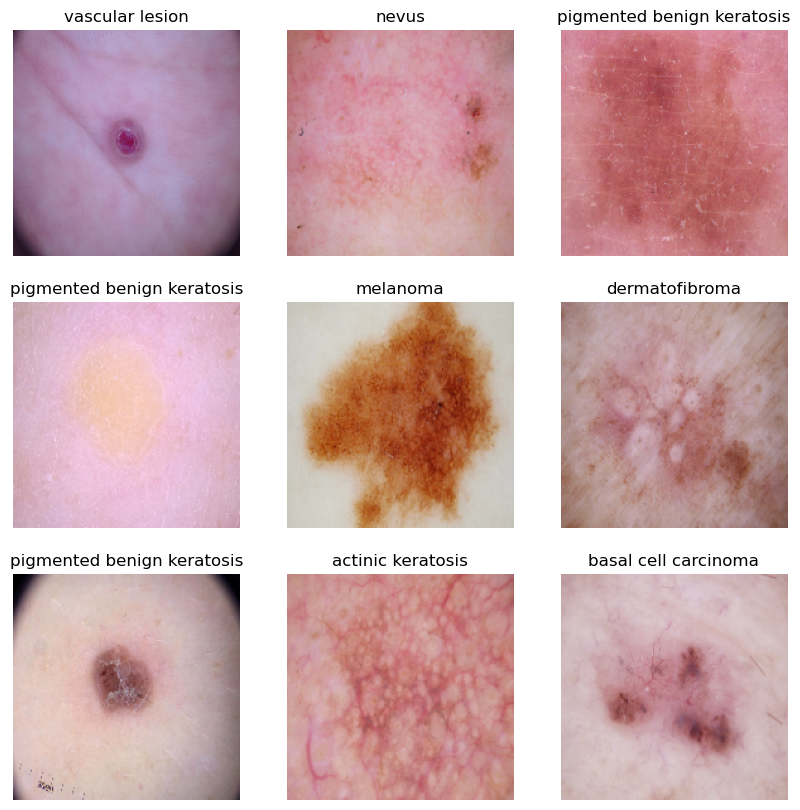

In [9]:
# visualize one instance of all the nine classes present in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
# Define the CNN model
model = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with 512 units
    layers.Dense(512, activation='relu'),
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 680ms/step - accuracy: 0.2298 - loss: 2.5635 - val_accuracy: 0.4497 - val_loss: 1.5681
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.4191 - loss: 1.6285 - val_accuracy: 0.4855 - val_loss: 1.4929
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - accuracy: 0.4819 - loss: 1.4453 - val_accuracy: 0.5257 - val_loss: 1.4167
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.5394 - loss: 1.3253 - val_accuracy: 0.5548 - val_loss: 1.3647
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 625ms/step - accuracy: 0.5717 - loss: 1.2182 - val_accuracy: 0.5101 - val_loss: 1.3908
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 640ms/step - accuracy: 0.5856 - loss: 1.1575 - val_accuracy: 0.5436 - val_loss: 1.3445
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 639ms/step - accuracy: 0.6161 - loss: 1.0563 - val_accuracy: 0.5459 - val_loss: 1.3743
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 666ms/step - accuracy: 0.6288 - loss: 1.0655 - val_accu

### Visualizing training results

In [15]:
# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

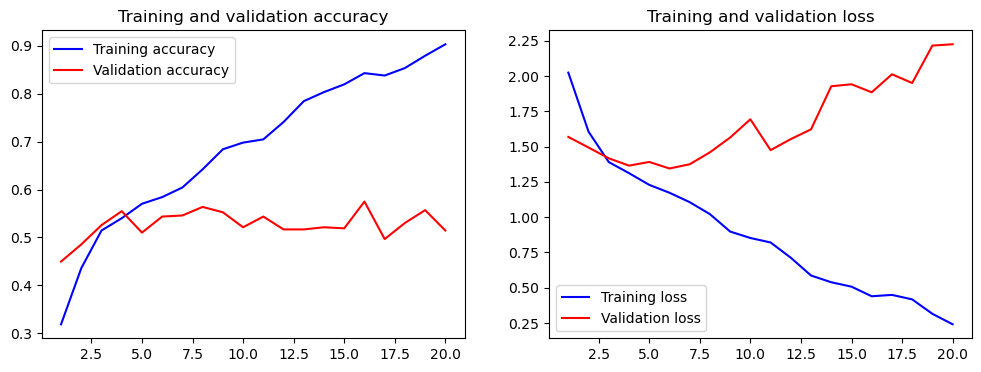

In [16]:
plot_history(history)

#### Observations:

- Training accuracy improves steadily, but validation accuracy plateaus and fluctuates, indicating possible overfitting.

- Training loss decreases consistently, while validation loss increases after a point, confirming overfitting.

- The model fits well to the training data but struggles to generalize to validation data.

### Write your findings here

In [17]:
# Balanced augmentation


# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the image by up to 20 degrees
    zoom_range=0.1,          # Random zoom up to 10%
    width_shift_range=0.1,   # Horizontal shift by 10%
    height_shift_range=0.1,  # Vertical shift by 10%
    horizontal_flip=True,    # Random horizontal flipping
    fill_mode='nearest',     # Fill strategy for new pixels after shift/rotation
    validation_split=0.2     # Split the dataset for validation
)

# No augmentation for validation data
val_datagen = ImageDataGenerator(
    validation_split=0.2  # Only splitting for validation, no augmentation
)

# Load training data with augmentation (subset='training')
train_ds_aug = datagen.flow_from_directory(
    data_dir_train,               # Path to training data directory
    target_size=(180, 180),   # Resize images to 180x180
    batch_size=32,            # Batch size
    class_mode='categorical', # Multi-class classification
    subset='training',        # Select the training data subset (80%)
    seed=123                  # For reproducibility
)

# Load validation data without augmentation (subset='validation')
val_ds = val_datagen.flow_from_directory(
    data_dir_train,               # Same directory, but without augmentation
    target_size=(180, 180),   # Resize images to 180x180
    batch_size=32,
    class_mode='categorical',
    subset='validation',     # Select the validation data subset (20%)
    seed=123
)



Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


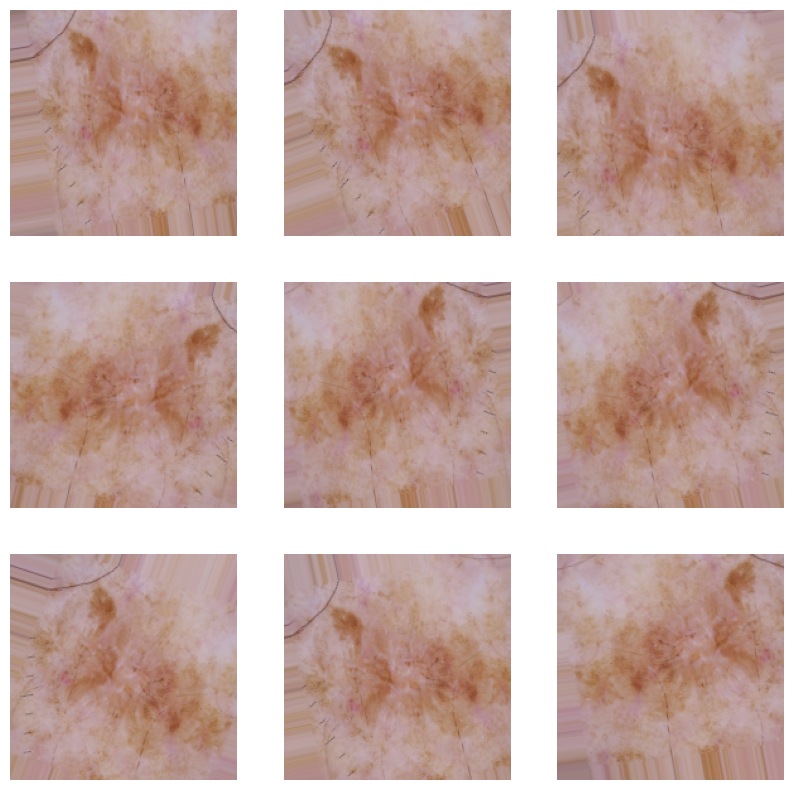

In [18]:
# Visualizing how augmentation strategy works for one instance of training image.

# Load one image from the training dataset
for images, _ in train_ds.take(1):  
    img = images[0].numpy().astype('uint8')  # Take the first image and convert it to numpy array

# Reshape the image for the generator 
img = np.expand_dims(img, 0)

# Generate augmented images from the single image
augmented_images = datagen.flow(img, batch_size=1)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 augmented images
    plt.subplot(3, 3, i + 1)
    aug_img = next(augmented_images)[0].astype('uint8')  # Generate next augmented image
    plt.imshow(aug_img)
    plt.axis('off')

plt.show()

### Create the model for augmented data


In [19]:
# Define the CNN model with Dropout layers
model_aug = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First convolutional layer 
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D((2, 2)),
    
    
    # Second convolutional layer 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
    layers.MaxPooling2D((2, 2)),
    
    
    
    # Third convolutional layer 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D((2, 2)),
   
   
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model

In [20]:
model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

In [21]:
model_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [22]:
history_aug = model_aug.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs
)

C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.2070 - loss: 2.4861 - val_accuracy: 0.2905 - val_loss: 2.0662
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3187 - loss: 2.0018 - val_accuracy: 0.3829 - val_loss: 1.8541
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4278 - loss: 1.7443 - val_accuracy: 0.2905 - val_loss: 2.0454
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4520 - loss: 1.6677 - val_accuracy: 0.3851 - val_loss: 2.0472
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4748 - loss: 1.6548 - val_accuracy: 0.4572 - val_loss: 2.1148
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4725 - loss: 1.6306 - val_accuracy: 0.4302 - val_loss: 1.9498
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4954 - loss: 1.5691 - val_accuracy: 0.4437 - val_loss: 1.9080
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5258 - loss: 1.5017 - val_accuracy: 0.4032 - val_loss:

### Visualizing the results

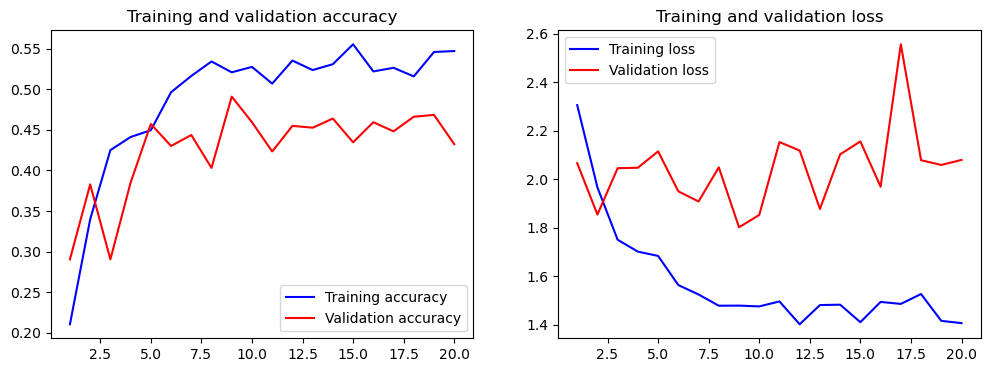

In [23]:
plot_history(history_aug)

#### Observation:

- Training accuracy steadily increases, while validation accuracy fluctuates without significant improvement, indicating limited generalization.
- Training loss decreases consistently, but validation loss remains high and unstable, further suggesting overfitting.
- The model fits the training data but struggles to perform consistently on validation data.

#### Finding the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
# Generate a list of all image file paths in the training data directory.
# This searches for all `.jpg` files within subdirectories of `data_dir_train`.
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 

# Extract the lesion labels by taking the name of the parent directory for each image.
# The parent directory represents the class or label of the image.
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

# Print the total number of labels (i.e., the total number of images in the dataset).
print(len(lesion_list))

2239


In [25]:
# Create a dictionary that maps each image file path to its corresponding lesion label.
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('D:\\mel\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('D:\\mel\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis')]


In [26]:
# Convert the dictionary of image paths and labels into a Pandas DataFrame.
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,D:\mel\Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,D:\mel\Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,D:\mel\Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,D:\mel\Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,D:\mel\Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


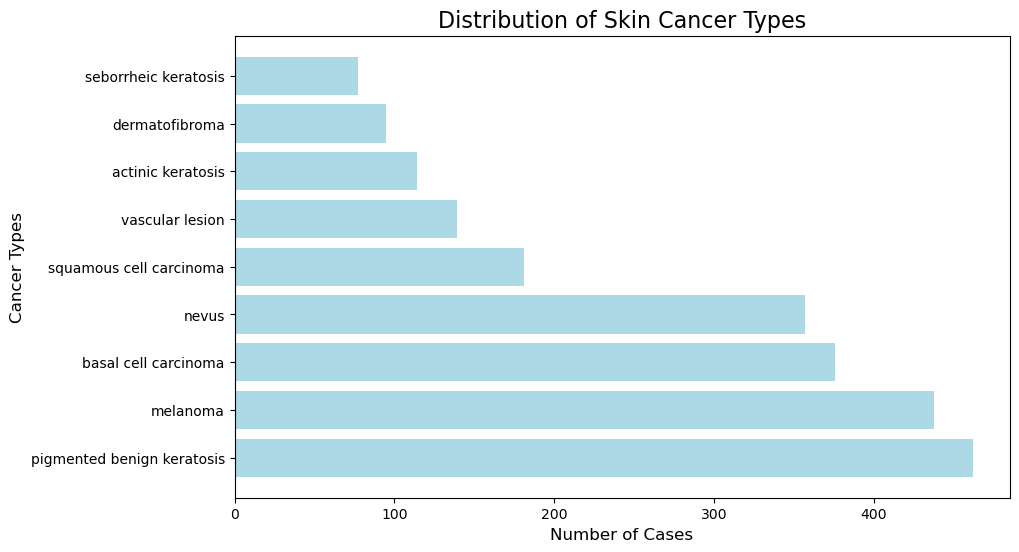

In [27]:
value_counts = original_df['Label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(value_counts.index, value_counts.values, color='lightblue')

# Add title and labels
plt.title('Distribution of Skin Cancer Types', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)

# Display the plot
plt.show()

#### Observations

 - Seborrheic keratosis class has the least number of samples.

 - Pigmented benign keratosis, melanoma, basal cell carcinoma and nevus classes dominate the data in terms proportionate number of samples.


#### Rectifying the class imbalance using Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:\mel\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F4375CD10>: 100%|█| 500/500 [00:05<00:00, 99.95 Samples/


Initialised with 376 image(s) found.
Output directory set to D:\mel\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21036E70F10>: 100%|█| 500/500 [00:05<00:00, 88.52 Samples/


Initialised with 95 image(s) found.
Output directory set to D:\mel\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21036FBF590>: 100%|█| 500/500 [00:05<00:


Initialised with 438 image(s) found.
Output directory set to D:\mel\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=965x624 at 0x21036F17A90>: 100%|█| 500/500 [00:29<00:00, 17.22 Samples/


Initialised with 357 image(s) found.
Output directory set to D:\mel\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x21036F66E50>: 100%|█| 500/500 [00:23<0


Initialised with 462 image(s) found.
Output directory set to D:\mel\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21036ED7D10>: 100%|█| 500/500 [00:05<00:00, 94.00 Samples/


Initialised with 77 image(s) found.
Output directory set to D:\mel\Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x21037AD8ED0>: 100%|█| 500/500 [00:11<00


Initialised with 181 image(s) found.
Output directory set to D:\mel\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21036FA3FD0>: 100%|█| 500/500 [00:05<00:00, 91.29 Samples/


Initialised with 139 image(s) found.
Output directory set to D:\mel\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x210342810D0>: 100%|█| 500/500 [00:05<00:00, 87.88 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['D:\\mel\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0176df2c-7881-4542-96d5-816b4d8de891.jpg',
 'D:\\mel\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4cb95144-0dc2-41cc-8e05-0290594e192b.jpg']

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['actinic keratosis', 'actinic keratosis']

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

# Check the shape of the new DataFrame
new_df.shape

(6739, 2)

In [34]:
new_df.head()

,Path,Label
0,D:\mel\Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,D:\mel\Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,D:\mel\Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,D:\mel\Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,D:\mel\Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


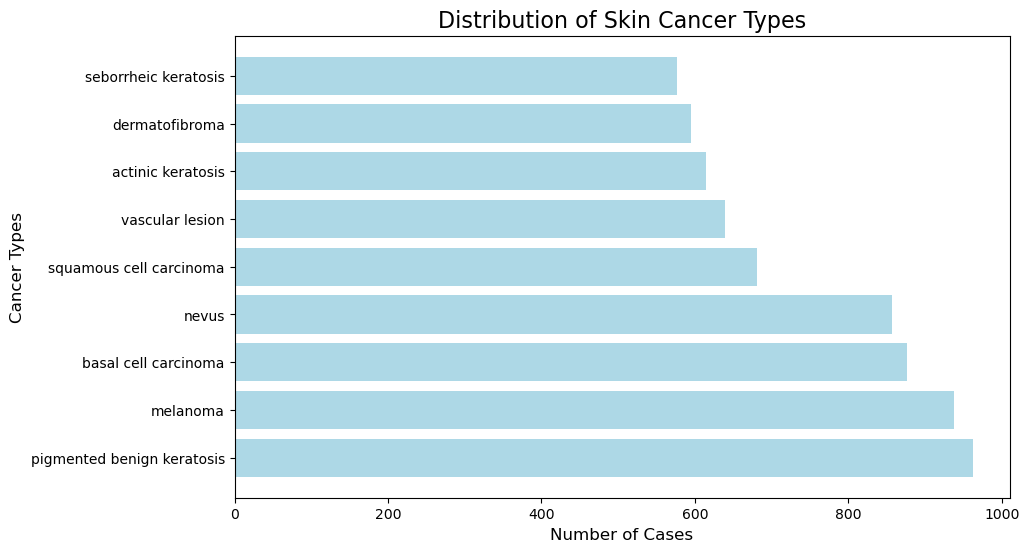

In [35]:
value_counts = new_df['Label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(value_counts.index, value_counts.values, color='lightblue')

# Add title and labels
plt.title('Distribution of Skin Cancer Types', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)

# Display the plot
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training and validation dataset

In [37]:
train_datagen = ImageDataGenerator(    
    validation_split=0.2  # Split the training data into train and validation sets
)

# Prepare training and validation datasets
train_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    seed = 123,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    seed = 123,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


#### Create model with normalization

In [38]:
model_bal = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3),),
    
    # First convolutional layer with Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
   
    
    # Second convolutional layer with Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    
    
    # Third convolutional layer with Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile model

In [39]:
model_bal.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

##### Train model

In [40]:
epochs = 30
history_bal = model_bal.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.3401 - loss: 4.1155 - val_accuracy: 0.1890 - val_loss: 4.5323
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.5173 - loss: 2.8448 - val_accuracy: 0.1749 - val_loss: 3.9391
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.6048 - loss: 2.3518 - val_accuracy: 0.3333 - val_loss: 3.2137
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6499 - loss: 2.2386 - val_accuracy: 0.3080 - val_loss: 3.9871
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.6734 - loss: 2.3983 - val_accuracy: 0.3482 - val_loss: 4.0307
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7362 - loss: 2.1685 - val_accuracy: 0.6079 - val_loss: 2.6655
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.7540 - loss: 2.3949 - val_accuracy: 0.4249 - val_loss: 4.1464
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7699 - loss: 2.6164 - val_accu

####  Visualize the model results

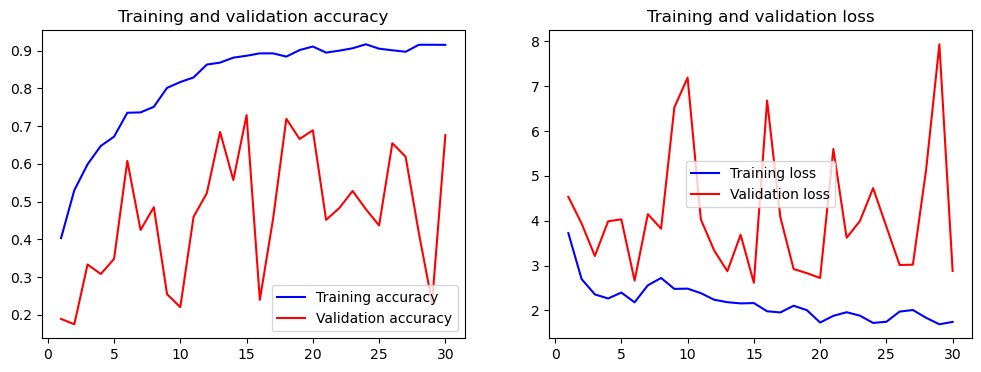

In [41]:
plot_history(history_bal)

#### Observations

- Training accuracy steadily increases and reaches high levels, but validation accuracy is highly unstable, indicating poor generalization.
- Training loss decreases steadily, while validation loss fluctuates widely, confirming instability and potential overfitting.

- After using batch normalization, there is large fluctuations in validation metrics suggesting instability and a need for improvements like regularization


In [42]:
train_datagen = ImageDataGenerator(    
    validation_split=0.2  # Split the training data into train and validation sets
)

# Prepare training and validation datasets
train_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


##### Model without batch normalization and with l2 regularizers

In [43]:
model_bal1 = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3),),
    
    # First convolutional layer with Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
   
    
    # Second convolutional layer with Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    
    # Third convolutional layer with Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

##### compile model

In [44]:
# Set custom learning rate for the Adam optimizer
learning_rate = 0.0001

# Compile the model
model_bal1.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##### Train the model

In [45]:
epochs = 30
history_bal1 = model_bal1.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.1847 - loss: 2.8664 - val_accuracy: 0.3624 - val_loss: 2.0365
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.3823 - loss: 1.9829 - val_accuracy: 0.4182 - val_loss: 1.8006
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4564 - loss: 1.7440 - val_accuracy: 0.4874 - val_loss: 1.5733
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.4921 - loss: 1.6080 - val_accuracy: 0.5149 - val_loss: 1.5401
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5328 - loss: 1.4702 - val_accuracy: 0.5052 - val_loss: 1.4694
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5607 - loss: 1.4300 - val_accuracy: 0.5275 - val_loss: 1.4148
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5821 - loss: 1.3635 - val_accuracy: 0.5878 - val_loss: 1.3013
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6026 - loss: 1.2825 - val_accu

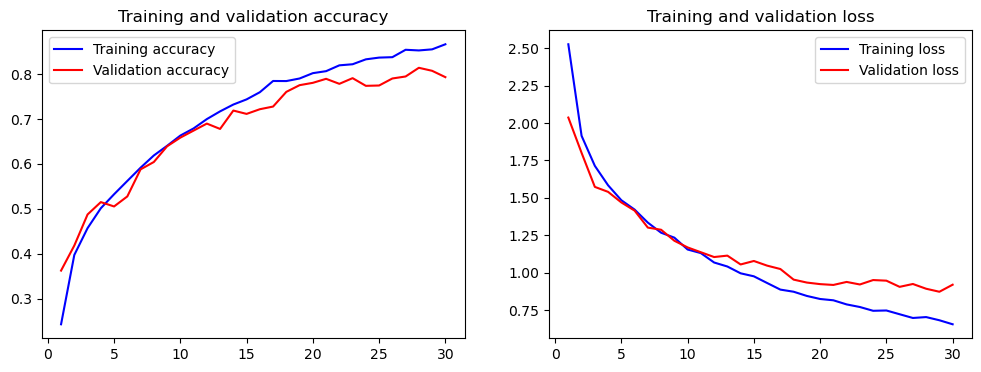

In [46]:
plot_history(history_bal1)

#### Observations: 

- Accuracy: Both training and validation accuracy improve steadily, with validation accuracy slightly lagging behind training accuracy.
- Loss: Both training and validation loss decreases consistently, indicating effective learning

##### Increasing epochs to see if validation accuracy is still improving at the end.

In [47]:
## CNN Model
model_bal2 = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3),),
    
    # First convolutional layer with Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
   
    
    # Second convolutional layer with Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    
    # Third convolutional layer with Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

In [48]:
# Set custom learning rate for the Adam optimizer
learning_rate = 0.0001

# Compile the model
model_bal2.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
#Train Model
epochs = 50
history_bal2 = model_bal2.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.1886 - loss: 2.8698 - val_accuracy: 0.3147 - val_loss: 2.0601
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.3484 - loss: 2.0520 - val_accuracy: 0.4152 - val_loss: 1.8008
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4334 - loss: 1.7863 - val_accuracy: 0.4650 - val_loss: 1.6158
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4823 - loss: 1.6135 - val_accuracy: 0.5134 - val_loss: 1.5305
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 166s 982ms/step - accuracy: 0.5306 - loss: 1.4979 - val_accuracy: 0.5193 - val_loss: 1.4676
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 159s 939ms/step - accuracy: 0.5572 - loss: 1.4408 - val_accuracy: 0.5670 - val_loss: 1.3854
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 152s 902ms/step - accuracy: 0.5730 - loss: 1.4079 - val_accuracy: 0.5625 - val_loss: 1.3448
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 159s 938ms/step - accuracy: 0.6053 - loss: 1.327

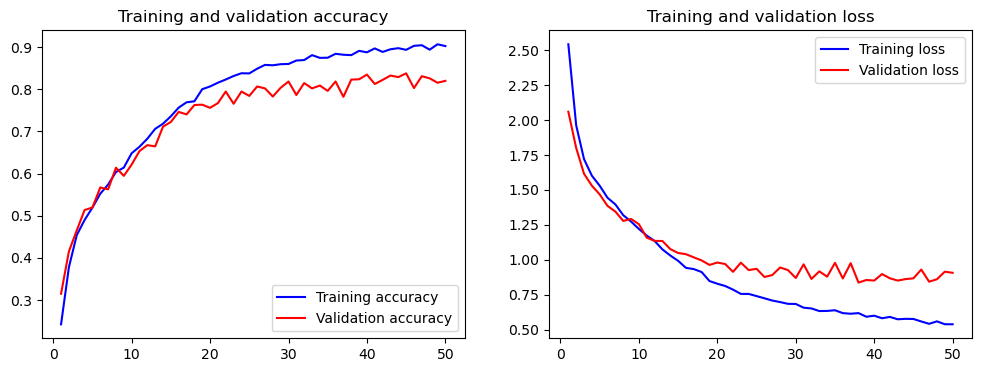

In [50]:
plot_history(history_bal2)

##### Observations

- The training and validation accuracy steadily increase as the epochs progress, with both curves showing convergence around epoch 40.
- Both training and validation loss consistently decrease over time, showing the model's learning progress.

- The model is learning effectively, with good performance on both training and validation data.
- Slight overfitting is observed but seems manageable.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


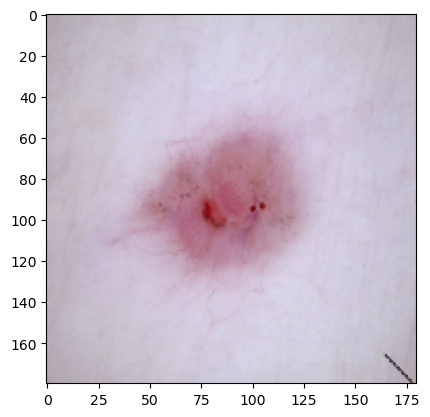

In [51]:
import PIL
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

# Construct the path to a test image
test_image_path = os.path.join(data_dir_test, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[8], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)

In [52]:
batch_size = 32
img_height = 180
img_width = 180

# Create the training and validation datasets with 80-20 split
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,                      # Fixed seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    batch_size=batch_size          # Use the specified batch size
)

Found 118 files belonging to 9 classes.


In [53]:
# Set custom learning rate for the Adam optimizer
learning_rate = 0.0001

# Compile the model
model_bal2.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
epochs = 30
history_test = model_bal2.fit(
  test_dataset,
  epochs=epochs
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step - accuracy: 0.3645 - loss: 4.4111
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 706ms/step - accuracy: 0.3708 - loss: 2.8045
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 688ms/step - accuracy: 0.3927 - loss: 2.5850
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 707ms/step - accuracy: 0.5367 - loss: 1.6918
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 691ms/step - accuracy: 0.6107 - loss: 1.4030
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.6269 - loss: 1.3757
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 666ms/step - accuracy: 0.6871 - loss: 1.1623
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 693ms/step - accuracy: 0.7486 - loss: 1.0629
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 699ms/step - accuracy: 0.7139 - loss: 1.0508
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - accuracy: 0.7754 - loss: 0.8935
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 704ms/step - accuracy: 0.7752 - loss: 0.9407
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 694ms/step - accuracy: 0.8429 - lo

### Conclusions

1) Data augmentation and L2 regularization reduce overfitting, improving generalization, while batch normalization alone causes instability. 
2) Regularization and balanced training enhance performance.